In [1]:
import warnings, pickle, os, itertools

import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 300)

from IPython.display import display
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(rc={'figure.figsize':(10,10)})

import shap
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

%load_ext autoreload
%autoreload 1

In [2]:
from utils.evaluation import plot_roc_curves, plot_pr_curves, plot_alert_rate, get_metrics
from models import Estimator_LightGBM, Estimator_L1Regression, Estimator_L2Regression, Estimator_LinearSVM, Estimator_LogisticRegression, Estimator_OneClassSVM, Estimator_RandomForest, Estimator_XGBoost, Resampler_RandomUnderSampler, Resampler_SMOTE
from systematic_comparison import get_xy
%aimport utils.evaluation, models, systematic_comparison

In [3]:
class Notebook:
    RESULTS_DIR = 'models/systematic'
    IMAGE_DIR = 'results/images/systematic'

In [6]:
from sklearn.model_selection import train_test_split
from dataset import SCIData, SCICols
%aimport dataset

sci = SCIData.load('data/sci.h5')

scii = (
    SCIData(
        SCIData.quickload("data/sci_processed.h5").sort_values("AdmissionDateTime")
    )
    .mandate(SCICols.news_data_raw)
    .augment_shmi(onehot=True)
    .derive_ae_diagnosis_stems(onehot=False)
)

sci_train, sci_test = train_test_split(
    scii,
    test_size=0.33,
    random_state=42,
    shuffle=False,
)
sci_train, sci_test = SCIData(sci_train), SCIData(sci_test)
X_train, X_test, y_train, y_test = get_xy(scii, Estimator_LightGBM, scii.feature_group_combinations['all'], outcome_within=1)

In [75]:
result_files = [f'{Notebook.RESULTS_DIR}/{_}' for _ in os.listdir(Notebook.RESULTS_DIR) if _.endswith('.h5')]
y_preds = pd.concat([pd.read_hdf(_, 'y_preds') for _ in result_files], axis=1).reset_index(drop=True)
metrics = pd.concat([pd.read_hdf(_, 'metrics') for _ in result_files], axis=0).reset_index(drop=True)
#hyperparameters = {name: optuna.load_study(study_name = name, storage=Notebook.STORAGE).best_params for name in metrics.name.values}

In [6]:
metrics = metrics[metrics.estimator != 'OneClassSVM'].copy()
y_preds = y_preds[metrics.name.values].copy()

## Dataset

In [8]:
select_num_cols = dict(
    Age='Age (years)', 
    TotalLOS='LOS (days)',
   # ReadmissionTimespan='Readmission',
    NEWS_score='NEWS',
    O2_saturation='SpO2 (%)',
    Respiration_rate='RR (breaths/min)',
    HeartRate='Pulse (beats/min)',
    SystolicBP='Systolic BP (mmHg)',
    DiastolicBP='Diastolic BP (mmHg)',
    Temperature='Temperature (oC)',
    Haemoglobin='Haemoglobin (g/L)',
    Urea_serum='Urea (mmol/L)',
    Sodium_serum='Sodium (mmol/L)',
    Potassium_serum='Potassium (mEg/L)',
    Creatinine='Creatinine (mmol/L)',
    Oxygen_flow_rate='FiO2 (%)'
)
select_num_cols_values = {
    _:scii[_] for _ in select_num_cols.keys()
} | dict(
    Oxygen_flow_rate = scii.Oxygen_flow_rate*100
   # ReadmissionTimespan = scii.ReadmissionTimespan.dt.days
)

pd.DataFrame([{
    'Variable': select_num_cols[k],
    'Mean +- Std': f'{v.mean():.2f} ± {v.std():.2f}',
    'Min': round(v.min(), 2),
    'Max': round(v.max(), 2)
} for k, v in select_num_cols_values.items()]).set_index('Variable')


,Mean +- Std,Min,Max
Variable,,,
Age (years),65.00 ± 20.47,0.0,121.00
LOS (days),6.82 ± 14.95,0.0,1491.17
NEWS,1.21 ± 1.68,0.0,18.00
SpO2 (%),96.57 ± 2.57,48.0,100.00
RR (breaths/min),17.68 ± 2.51,7.0,77.00
Pulse (beats/min),80.86 ± 15.43,26.0,194.00
Systolic BP (mmHg),126.74 ± 19.72,52.0,270.00
Diastolic BP (mmHg),70.14 ± 12.40,22.0,198.00
Temperature (oC),36.76 ± 0.51,30.8,41.10


In [15]:
select_categorical_cols = dict(
    AdmissionMethodDescription='Admission Pathway',
    AdmissionSpecialty='Admission Specialty',
    AandEPresentingComplaint='Presenting Complaint',
    BreathingDevice='Breathing Device',
    AandEMainDiagnosis='A&E Diagnosis'
)
select_categorical_cols_values = {
    _:scii[_] for _ in select_categorical_cols.keys()
} | dict(
)

In [39]:
scii.AandEPresentingComplaint.value_counts().head(5).to_frame(name='n').reset_index().assign(Column='test').set_index(['Column','index'])

n
Column index                               
test   other                          31527
       shortness of breath in adults  15026
       chest pain                     11587
       abdominal pain in adults        6414
       falls                           5280

In [55]:
pd.concat([(
    (v.value_counts().head(5).astype(str) + ' ('+
    (v.value_counts().head(5)/v.shape[0]*100).round(2).astype(str)+'%)')
    .to_frame(name='n (%)')
    .reset_index()
    .assign(Column=select_categorical_cols[k])
    .set_index(['Column', 'index'])
) for k, v in select_categorical_cols_values.items()])

n (%)
Column               index                                         
Admission Pathway    EMERGENCY A+E                  110847 (91.37%)
                     EMERGENCY GP REFER                5866 (4.84%)
                     BOOKED ADMISSION                  1807 (1.49%)
                     NON EM TRAN OTH PROV              1180 (0.97%)
                     EMERGENCY OPD                      899 (0.74%)
Admission Specialty  ACUTE INTERNAL MEDICINE         91187 (75.16%)
                     ACCIDENT & EMERGENCY             18322 (15.1%)
                     NEPHROLOGY                        3485 (2.87%)
                     GENERAL SURGERY                   2613 (2.15%)
                     TRAUMA & ORTHOPAEDICS             1234 (1.02%)
Presenting Complaint other                           31527 (25.99%)
                     shortness of breath in adults   15026 (12.39%)
                     chest pain                       11587 (9.55%)
                     abdominal pain in adults          6414 (5.29%)
                     falls                             5280 (4.35%)
Breathing Device     A - Air                        108892 (89.76%)
                     N - Nasal cannula                 8901 (7.34%)
                     SM - Simple mask                   685 (0.56%)
                     RM - Reservoir mask                394 (0.32%)
                     V28 - Venturi 28%                  391 (0.32%)
A&E Diagnosis        pain                               7162 (5.9%)
                     head                              2704 (2.23%)
                     fall                               1461 (1.2%)
                     collaps                           1245 (1.03%)
                     cope                               592 (0.49%)

In [62]:
shmi_counts = scii.augment_shmi(onehot=True)#[SCICols.diagnoses].stack()

In [65]:
scii.derive_critical_event(within=999).CriticalEvent.sum()

8563

In [19]:
scii['AandEPresentingComplaint'].value_counts().head(5)/scii.shape[0]

other                            0.259864
shortness of breath in adults    0.123853
chest pain                       0.095507
abdominal pain in adults         0.052868
falls                            0.043521
Name: AandEPresentingComplaint, dtype: float64

## NEWS

In [ ]:
baseline_news_performance = get_metrics(
    y_test,
    sci_test.NEWS_score >= 7,
    sci_test.NEWS_score
)

In [77]:
news_performance_thresholds = {n: get_metrics(
        sci_test.derive_critical_event(within=t, return_series=True),
        sci_test.NEWS_score >= 7,
        sci_test.NEWS_score
    ) for t, n in [(1, '24h'), (2, '48h'), (999, 'Any')]}


In [85]:
functions = {
    'Critical Event': sci_test.derive_critical_event,
    'Mortality':sci_test.derive_death_within,
    'Critical Care': sci_test.derive_critical_care,
}
thresholds = {
    '24h': 1,
    '48h': 2,
    'Any': 999
}

news_performances = [
    (outcome_name, threshold_name, get_metrics(
        function(within=threshold, return_series=True),
        sci_test.NEWS_score >= 7,
        sci_test.NEWS_score
    )) for (outcome_name, function) in functions.items() for (threshold_name, threshold) in thresholds.items()
]
pd.DataFrame([dict(
    Outcome=o,
    Threshold=t,
    AUC=f"{v['AUC']:.2f} ({v['AUC_Lower']:.2f}-{v['AUC_Upper']:.2f})",
    AP=f"{v['AP']:.2f} ({v['AP_Lower']:.2f}-{v['AP_Upper']:.2f})",
) for o, t, v in news_performances])

,Outcome,Threshold,AUC,AP
0,Critical Event,24h,0.80 (0.78-0.82),0.15 (0.14-0.17)
1,Critical Event,48h,0.82 (0.80-0.83),0.23 (0.21-0.25)
2,Critical Event,Any,0.77 (0.75-0.78),0.31 (0.29-0.32)
3,Mortality,24h,0.93 (0.89-0.96),0.17 (0.13-0.24)
4,Mortality,48h,0.92 (0.90-0.94),0.26 (0.21-0.31)
5,Mortality,Any,0.77 (0.76-0.78),0.24 (0.22-0.26)
6,Critical Care,24h,0.78 (0.77-0.81),0.10 (0.09-0.11)
7,Critical Care,48h,0.79 (0.77-0.81),0.12 (0.11-0.13)
8,Critical Care,Any,0.76 (0.75-0.78),0.12 (0.11-0.13)


## Metrics

In [187]:
metrics.iloc[metrics.groupby(['estimator']).AP.idxmax()].to_dict(orient='records')

,name,estimator,resampler,features,AUC,AUC_Upper,AUC_Lower,AP,AP_Upper,AP_Lower,Accuracy,Precision,Recall,F2,outcome_within
8,IsolationForest_None_news_scored_extended,IsolationForest,None,news_scored_extended,0.809508,0.826379,0.794253,0.229357,0.260422,0.204192,0.938805,0.198191,0.490835,0.378931,NaN
35,L1Regression_None_with_notes_labs_and_hospital,L1Regression,None,with_notes_labs_and_hospital,0.900282,0.911076,0.889013,0.486942,0.518822,0.455301,0.943351,0.245246,0.630346,0.479696,NaN
126,L2Regression_SMOTE_with_notes_labs_and_hospital,L2Regression,SMOTE,with_notes_labs_and_hospital,0.901593,0.912156,0.890185,0.488327,0.519628,0.458247,0.942402,0.241810,0.631365,0.477511,NaN
145,LightGBM_None_with_notes_labs_and_hospital,LightGBM,None,with_notes_labs_and_hospital,0.917352,0.926573,0.907001,0.527634,0.559428,0.496677,0.942752,0.248657,0.659878,0.495868,NaN
236,LinearSVM_SMOTE_with_notes_labs_and_hospital,LinearSVM,SMOTE,with_notes_labs_and_hospital,0.899566,0.910040,0.887961,0.475961,0.509080,0.444980,0.942252,0.240640,0.628310,0.475200,NaN
255,LogisticRegression_None_with_notes_labs_and_ho...,LogisticRegression,None,with_notes_labs_and_hospital,0.899724,0.910459,0.888176,0.489202,0.520669,0.458294,0.942502,0.240157,0.621181,0.471552,NaN
366,XGBoost_SMOTE_with_labs_and_diagnoses,XGBoost,SMOTE,with_labs_and_diagnoses,0.840306,0.856453,0.824857,0.353787,0.389267,0.323005,0.940079,0.211170,0.527495,0.405892,NaN


In [86]:
select_feature_groups = dict(
    news_scores='NEWS sub-scores',
    news='Vitals',
    news_with_phenotype='& Obs',
    with_labs='& Labs',
    with_notes_and_labs='& Notes',
    with_notes_labs_and_hospital='& Services'
)
df = metrics.loc[metrics[metrics.features.isin(select_feature_groups.keys())].groupby(['estimator', 'features']).AP.idxmax()]

In [213]:
pd.DataFrame([dict(
    Features=select_feature_groups[_['features']],
    Estimator=_['estimator'],
    AUC=f"{_['AUC']:.2f} ({_['AUC_Lower']:.2f}-{_['AUC_Upper']:.2f})",
    AP=f"{_['AP']:.2f} ({_['AP_Lower']:.2f}-{_['AP_Upper']:.2f})"
) for _ in df.to_dict(orient='records')]).sort_values('Features').set_index(['Features', 'Estimator'])

AUC                AP
Features      Estimator                                             
Hospital      XGBoost             0.92 (0.90-0.92)  0.52 (0.49-0.55)
              LogisticRegression  0.90 (0.89-0.91)  0.49 (0.46-0.52)
              IsolationForest     0.70 (0.68-0.72)  0.07 (0.06-0.07)
              LinearSVM           0.90 (0.89-0.91)  0.48 (0.44-0.51)
              LightGBM            0.92 (0.91-0.93)  0.53 (0.50-0.56)
              L2Regression        0.90 (0.89-0.91)  0.49 (0.46-0.52)
              L1Regression        0.90 (0.89-0.91)  0.49 (0.46-0.52)
Labs          XGBoost             0.86 (0.85-0.88)  0.39 (0.36-0.43)
              LogisticRegression  0.83 (0.82-0.85)  0.34 (0.31-0.38)
              LinearSVM           0.83 (0.82-0.85)  0.34 (0.30-0.37)
              L2Regression        0.83 (0.81-0.85)  0.34 (0.31-0.38)
              LightGBM            0.87 (0.85-0.88)  0.40 (0.37-0.44)
              IsolationForest     0.76 (0.75-0.78)  0.18 (0.16-0.21)
              L1Regression        0.83 (0.81-0.85)  0.34 (0.31-0.38)
Notes         LinearSVM           0.86 (0.85-0.88)  0.35 (0.32-0.38)
              IsolationForest     0.66 (0.64-0.69)  0.06 (0.05-0.07)
              LightGBM            0.89 (0.88-0.90)  0.42 (0.39-0.46)
              LogisticRegression  0.87 (0.86-0.88)  0.37 (0.34-0.41)
              L1Regression        0.87 (0.85-0.88)  0.37 (0.33-0.40)
              L2Regression        0.87 (0.85-0.88)  0.37 (0.34-0.40)
              XGBoost             0.89 (0.88-0.90)  0.42 (0.39-0.45)
Obs           LightGBM            0.85 (0.84-0.87)  0.39 (0.36-0.42)
              IsolationForest     0.77 (0.75-0.79)  0.20 (0.17-0.23)
              LinearSVM           0.82 (0.81-0.84)  0.34 (0.31-0.37)
              L1Regression        0.83 (0.81-0.84)  0.34 (0.31-0.37)
              L2Regression        0.82 (0.81-0.84)  0.34 (0.31-0.37)
              LogisticRegression  0.83 (0.81-0.84)  0.34 (0.31-0.38)
              XGBoost             0.85 (0.84-0.87)  0.39 (0.36-0.42)
Vitals (NEWS) XGBoost             0.87 (0.85-0.88)  0.27 (0.24-0.30)
              L2Regression        0.85 (0.83-0.86)  0.22 (0.20-0.25)
              L1Regression        0.85 (0.83-0.86)  0.22 (0.20-0.25)
              LinearSVM           0.85 (0.83-0.86)  0.22 (0.20-0.25)
              LightGBM            0.87 (0.85-0.88)  0.28 (0.25-0.31)
              LogisticRegression  0.85 (0.83-0.86)  0.22 (0.20-0.25)
              IsolationForest     0.83 (0.81-0.84)  0.21 (0.18-0.24)

In [276]:
df = metrics.loc[metrics[metrics.estimator.isin(['LightGBM', 'L1Regression', 'LinearSVM']) & metrics.features.isin(select_feature_groups.keys())].groupby(['estimator', 'features']).AUC.idxmax()]

for estimator in ['LightGBM', 'L1Regression'] :
    display(pd.DataFrame([dict(
        Estimator=_['estimator'],
        Features=select_feature_groups[_['features']],
        AUC=f"{_['AUC']:.2f} ({_['AUC_Lower']:.2f}-{_['AUC_Upper']:.2f})",
        AP=f"{_['AP']:.2f} ({_['AP_Lower']:.2f}-{_['AP_Upper']:.2f})"
    ) for _ in df[df.estimator==estimator].to_dict(orient='records')]))

,Estimator,Features,AUC,AP
0,LightGBM,Vitals (NEWS),0.87 (0.85-0.88),0.26 (0.23-0.29)
1,LightGBM,Obs,0.85 (0.84-0.87),0.38 (0.35-0.41)
2,LightGBM,Labs,0.87 (0.85-0.88),0.40 (0.37-0.44)
3,LightGBM,Notes,0.89 (0.88-0.90),0.42 (0.39-0.46)
4,LightGBM,Hospital,0.92 (0.91-0.93),0.53 (0.50-0.56)


,Estimator,Features,AUC,AP
0,L1Regression,Vitals (NEWS),0.85 (0.83-0.86),0.22 (0.20-0.25)
1,L1Regression,Obs,0.82 (0.81-0.84),0.34 (0.31-0.37)
2,L1Regression,Labs,0.83 (0.81-0.85),0.34 (0.31-0.38)
3,L1Regression,Notes,0.87 (0.85-0.88),0.37 (0.33-0.40)
4,L1Regression,Hospital,0.90 (0.89-0.91),0.48 (0.45-0.51)


In [10]:
def load_model(name):
    with open(f'{Notebook.RESULTS_DIR}/models/{name}.bin', 'rb') as file:
        model, explanations = pickle.load(file)
    return model, explanations

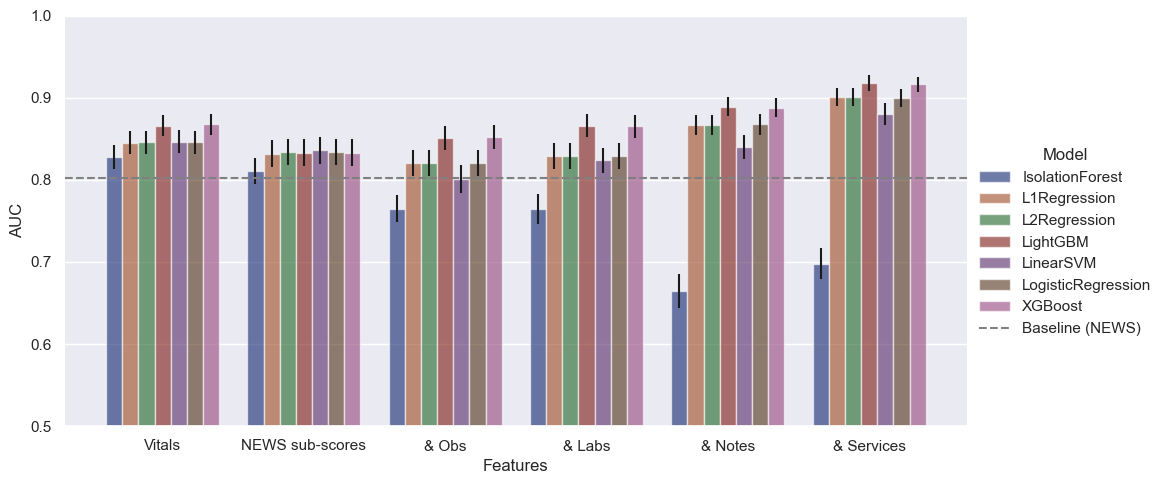

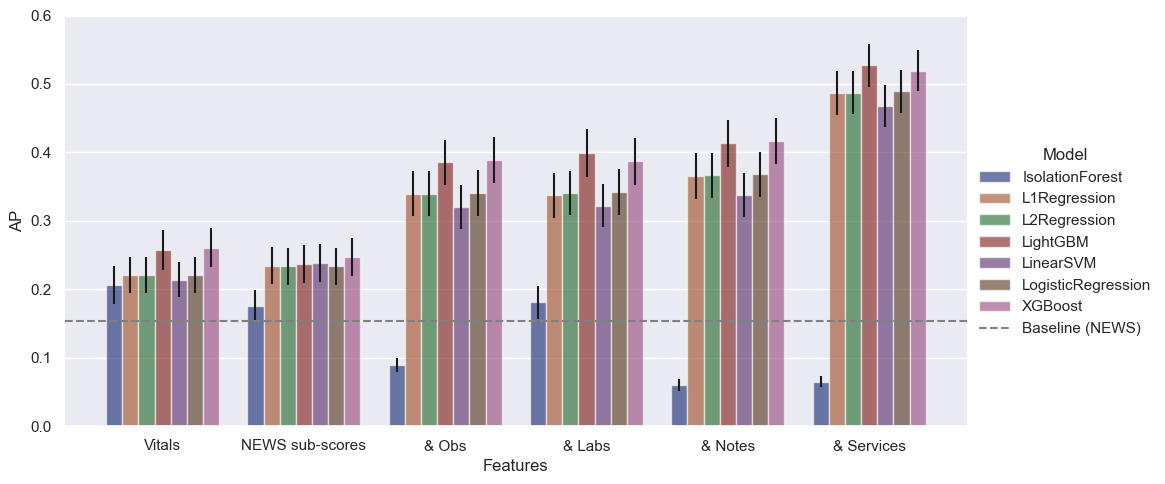

In [89]:
def select_feature_ablation_barplot(metrics, feature_groups, metric='AUC', ylim=(0.0, 1.0), baseline=None, save=None):
    sns.set_style('darkgrid')
    df = metrics[
        (metrics.features.isin(feature_groups.keys()))
        & (metrics.resampler == 'None')
    ].rename(columns=dict(
        features='Features',
        estimator='Model'
    ))
    err = (df[f'{metric}_Upper']-df[f'{metric}_Lower'])/2
    df['Features'] = df.Features.replace(feature_groups)
    g = sns.catplot(
        data=df, x='Features', y=metric, hue='Model',
        kind='bar', palette='dark', alpha=.6, height=6, orient='v', legend=False
    )
    g.despine(left=True)
    g.fig.set_size_inches(10,5)
    g.ax.set_ylim(ylim)
    x_coords = [p.get_x() + 0.5*p.get_width() for p in g.ax.patches]
    y_coords = [p.get_height() for p in g.ax.patches]
    g.ax.errorbar(x=x_coords, y=y_coords, yerr=err, fmt="none", c= "k")

    if baseline is not None:
        g.refline(y = baseline[metric], color = 'gray', linestyle = '--', label = "Baseline (NEWS)") 
        g.add_legend(title='Model')
    
    if save:
        plt.savefig(save, bbox_inches="tight", dpi=100)

select_feature_ablation_barplot(metrics, select_feature_groups, 'AUC', (0.5, 1.0), baseline=baseline_news_performance, save=f'{Notebook.IMAGE_DIR}/auc_bar.png')
select_feature_ablation_barplot(metrics, select_feature_groups, 'AP', (0.0, 0.6), baseline=baseline_news_performance, save=f'{Notebook.IMAGE_DIR}/ap_bar.png')

In [11]:
model, explanations = load_model('L1Regression_None_all')

Trying to unpickle estimator StandardScaler from version 1.1.3 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator ColumnTransformer from version 1.1.3 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator LogisticRegression from version 1.1.3 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator IsotonicRegression from version 1.1.3 when using version 1.1.2. This might lead to breaking code or inv

In [70]:
y_pred_proba =model.predict_proba(get_xy(scii, Estimator_L1Regression, scii.feature_group_combinations['all'], outcome_within=1)[1])[:,1]

In [79]:
y_test

119085    False
92376     False
100253    False
30606     False
44730      True
          ...  
29619     False
41774     False
140229    False
79460     False
17697     False
Length: 40036, dtype: bool

In [9]:
roc_auc_score(y_test.values, y_preds.XGBoost_None_all.values)

0.4869963935722414

In [98]:
def best_performers(metrics, baseline=True):
    df = metrics.iloc[metrics.groupby('estimator').AP.idxmax()]
    preds = dict(zip(df.estimator.values, [y_preds[_] for _ in df.name.values]))
    return roc_auc_score(y_test, preds['L1Regression'])
    if baseline:
        preds['Baseline (NEWS)'] = sci_test.NEWS_score
    plot_pr_curves(y_test, preds)
    return df

best_performers(metrics)

0.5020388845328491

In [22]:
metrics.iloc[53]['name']

'LightGBM_RandomUnderSampler_with_notes_labs_and_hospital'

In [25]:
model, explanations = load_model('LightGBM_RandomUnderSampler_with_notes_labs_and_hospital')

Trying to unpickle estimator LabelEncoder from version 1.0.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator IsotonicRegression from version 1.0.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator CalibratedClassifierCV from version 1.0.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations


In [36]:
from utils.evaluation import plot_shap_features_joint, plot_calibrated_regression_coefficients

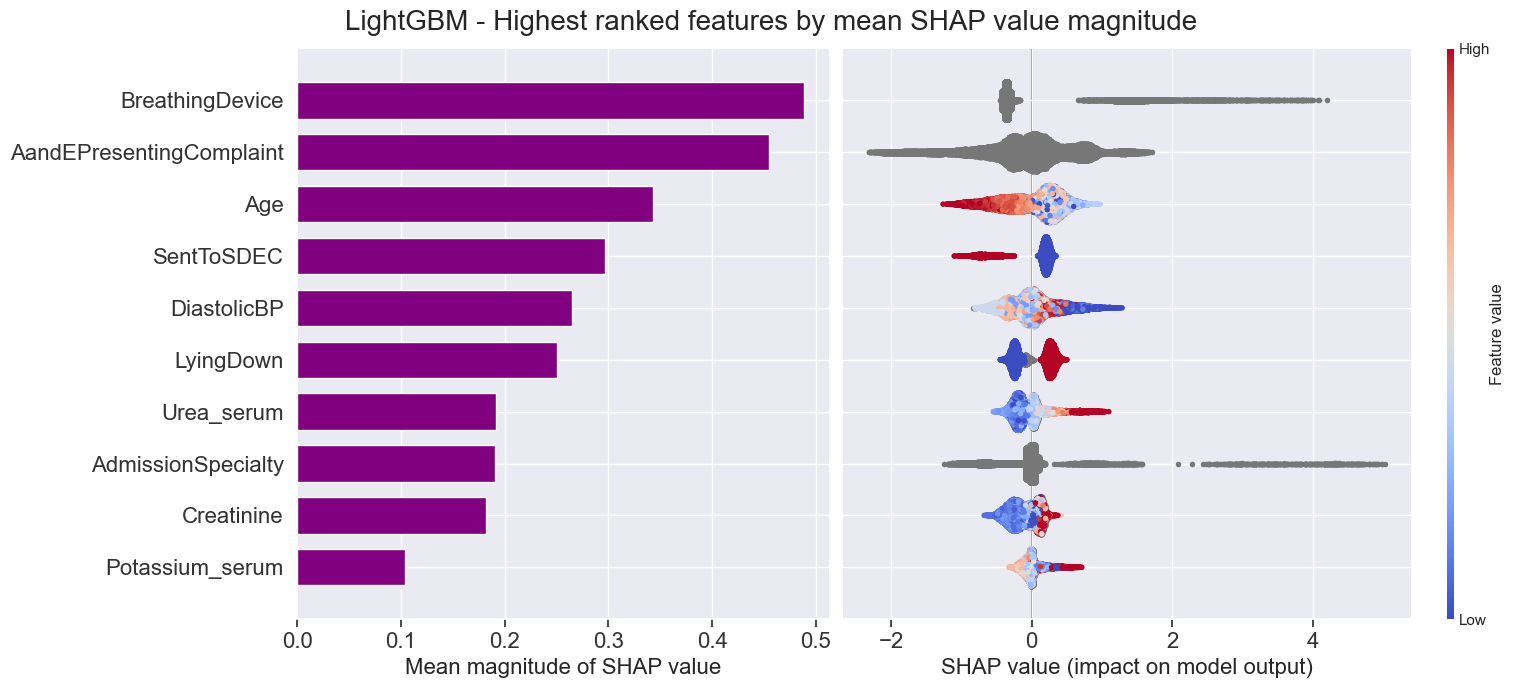

In [29]:
plot_shap_features_joint(
    explanations, 
    "LightGBM - Highest ranked features by mean SHAP value magnitude",
    max_display=10,
    figsize=(16, 7),
    wspace=-0.105,
    bar_aspect=0.050,
    topadjust=0.925,
)

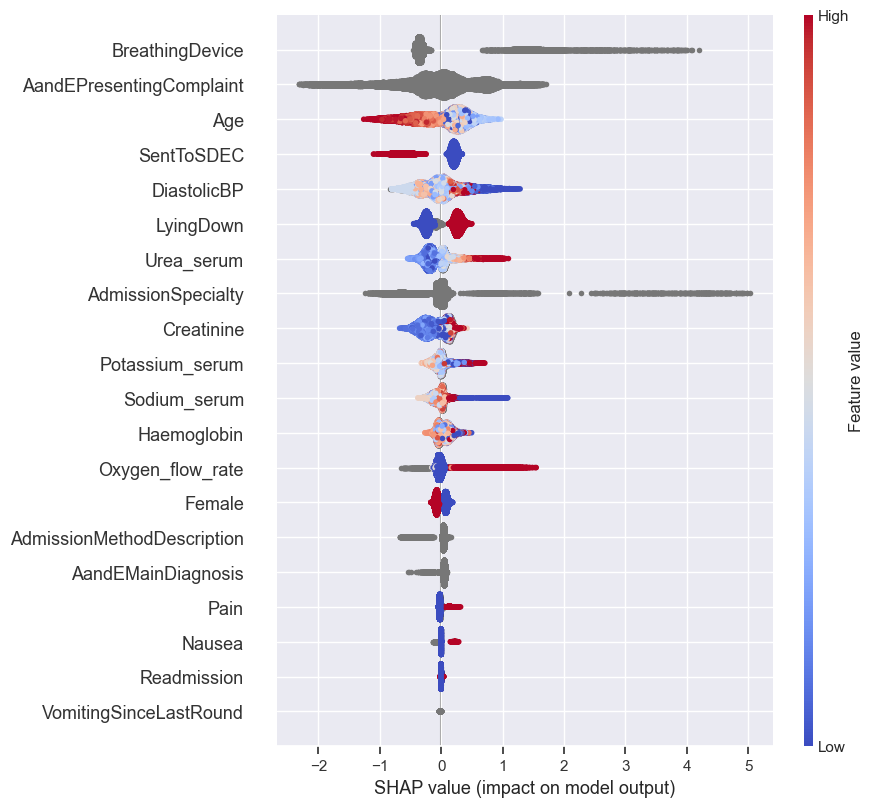

In [31]:
fig = shap.plots.beeswarm(
    explanations,
    max_display=20,
    show=False,
    color=plt.get_cmap("coolwarm"),
)

Text(0.5, 1.0, 'LightGBM')

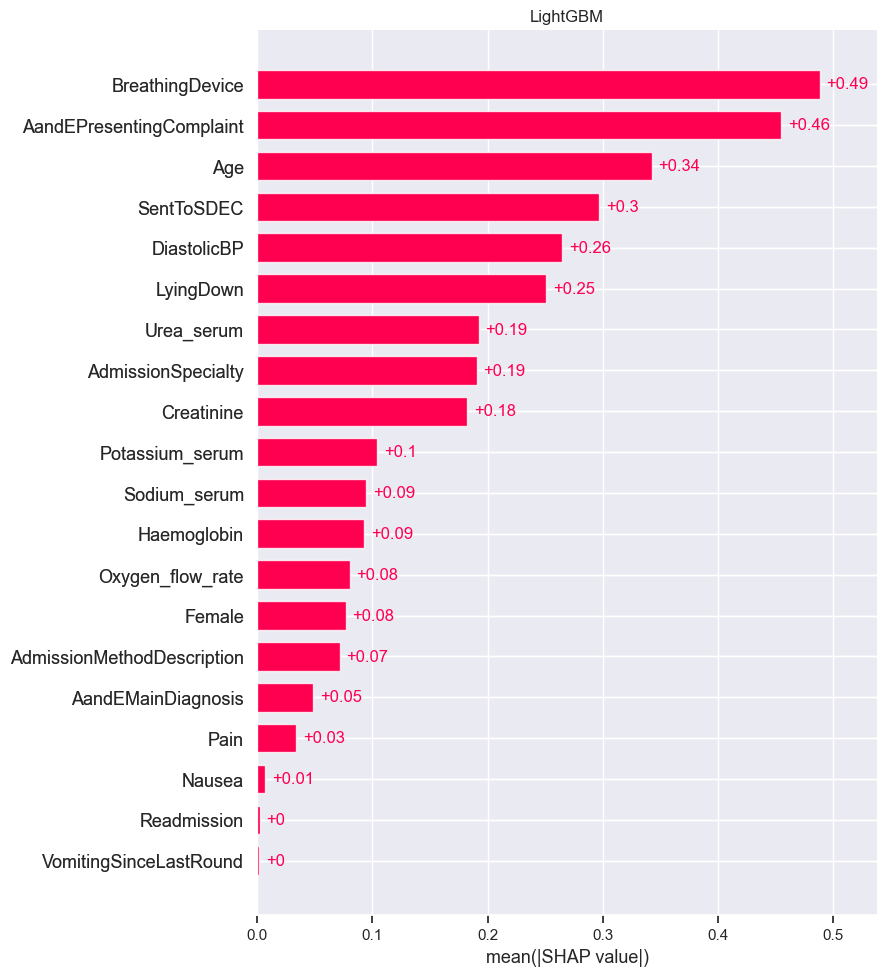

In [35]:
fig = shap.plots.bar(
    explanations, max_display=20, show=False
)
plt.title("LightGBM")

In [153]:
model, explanations = load_model('LogisticRegression_None_with_labs_and_hospital')

Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator ColumnTransformer from version 1.0.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator LogisticRegression from version 1.0.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator IsotonicRegression from version 1.0.2 when using version 1.1.2. This might lead to breaking code or inv

In [158]:
X_train, _, y_train, _ = get_xy(scii, Estimator_LogisticRegression, features=scii.feature_group_combinations['with_labs_and_hospital'])
columns = X_train.columns
categories = X_train.get_onehot_categorical_columns()

In [160]:
model.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=Pipeline(steps=[('Scaling',
                                                       ColumnTransformer(remainder='passthrough',
                                                                         transformers=[('Scaler',
                                                                                        StandardScaler(),
                                                                                        ['VomitingSinceLastRound',
                                                                                         'DiastolicBP',
                                                                                         'LyingDown',
                                                                                         'Pain',
                                                                                         'Oxygen_flow_rate',
                                                                                         'Nausea',
                                                                                         'Age',
                                                                                         'Haemoglobin',
                                                                                         'Urea_serum',
                                                                                         'Sodium_serum',
                                                                                         'Potassium_serum',
                                                                                         'Creatinine'])])),
                                                      ('LogisticRegression',
                                                       LogisticRegression(max_iter=2000,
                                                                          penalty='none',
                                                                          random_state=42))]),
                       cv=5, method='isotonic', n_jobs=5)

In [161]:
from utils.evaluation import get_calibrated_regression_coefficients, regression_coefficient_sorted_barplot
coef = get_calibrated_regression_coefficients(model, columns, 'LogisticRegression')
def regression_coefficients_categorical(category='AandEPresentingComplaint', title=None, save=None):
    df = coef[coef.Feature.isin(categories[category])].copy()
    df['Feature'] = df.Feature.str.split('__').str[1].replace('-1', 'unknown')
    regression_coefficient_sorted_barplot(df, title=title, save=save)
#    plt.gca().invert_yaxis()


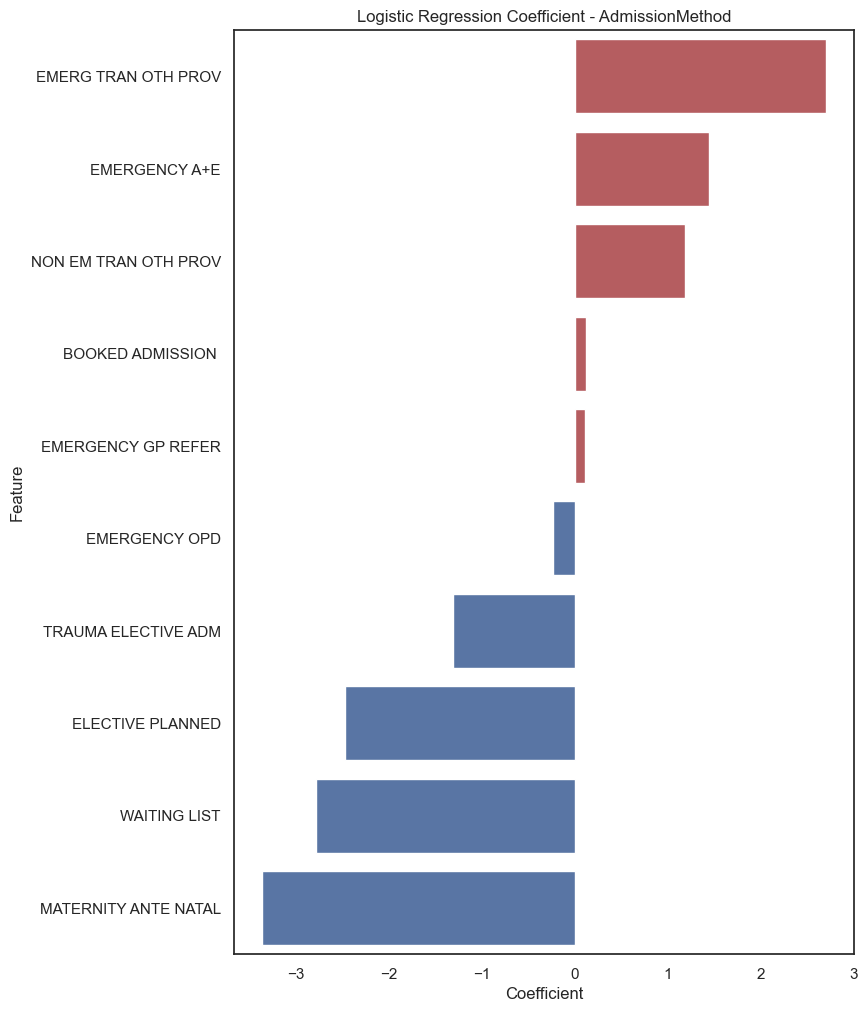

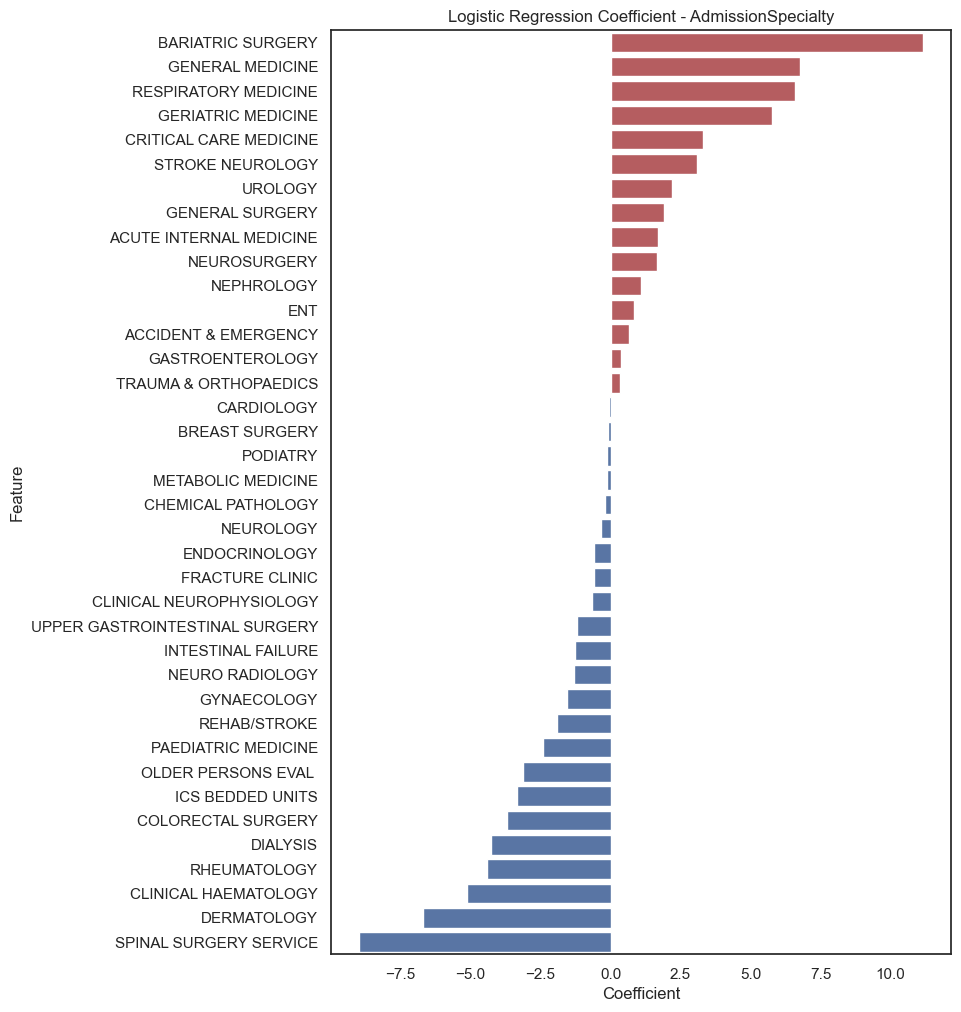

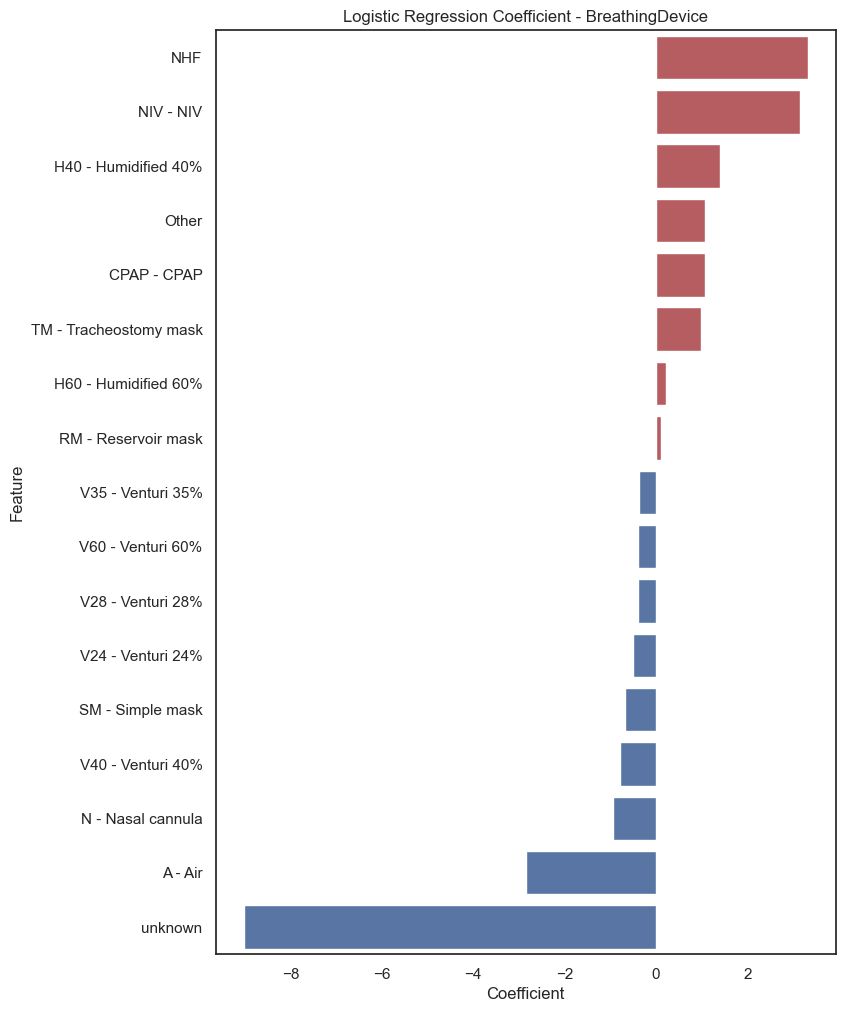

In [162]:
for _ in categories.keys():
    regression_coefficients_categorical(category=_, title=f'Logistic Regression Coefficient - {_}')

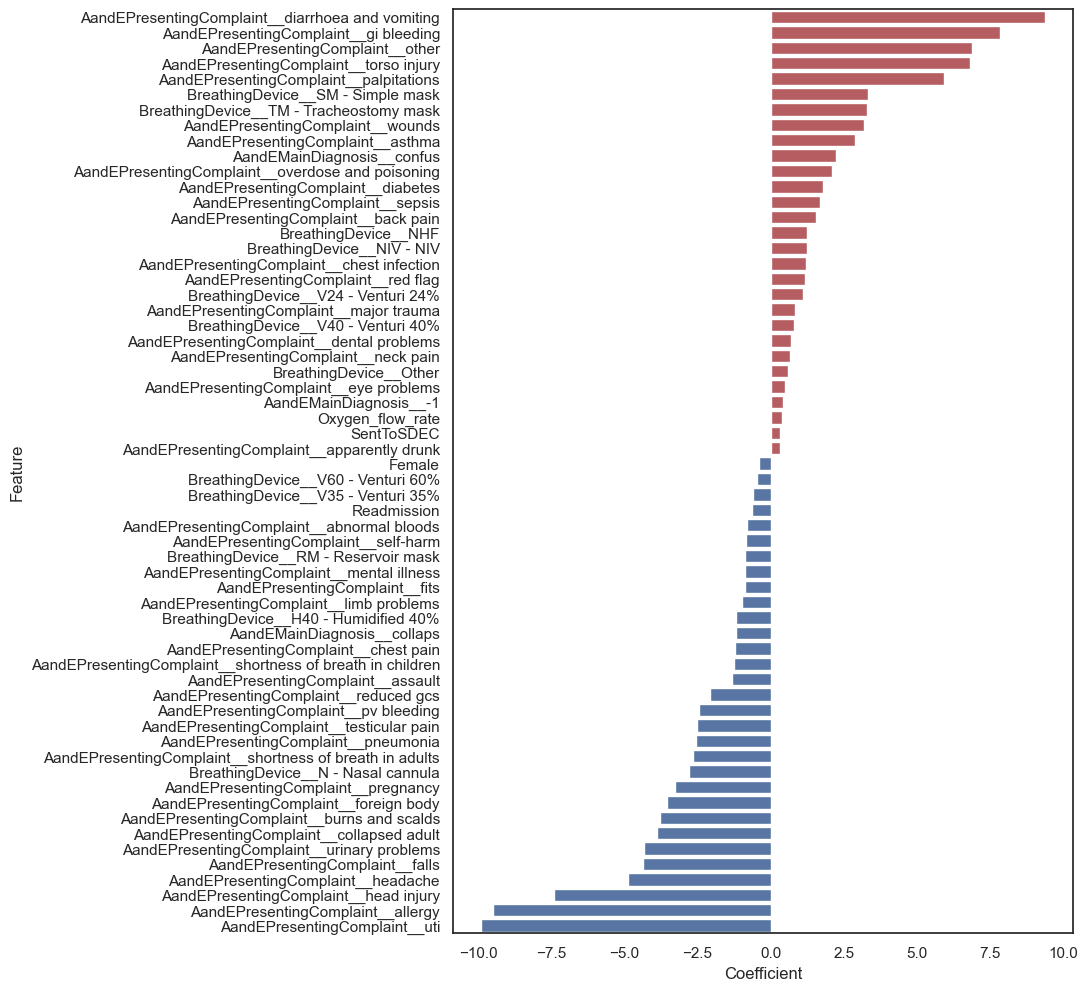

In [50]:
plot_calibrated_regression_coefficients(
    model,
    columns,
    pipeline_key='LogisticRegression'
)